# Event Sampling Demo
This notebook will use the code in the build_dataset to sample specific events from a processed crypto dataset. The process of event sampling and analysis will be roughly: Define the event, sample the event from the dataset, investigate the samples datapoints to find suitable prediction targets and holding periods.

In [56]:
%load_ext autoreload
%autoreload 2
from src.data import build_dataset as bd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_pickle(r'\crypto_forecast\data\raw\hour_sampled\XXBTZEUR_sampled.pkl')

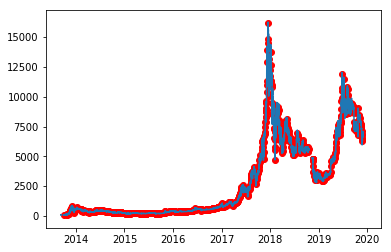

In [3]:
dVol = bd.getDailyVol(data.close)
tEvents = bd.getTEventsMod(np.log(data.close),dVol*2)
plt.plot(data.close)
plt.scatter(tEvents,data.close[tEvents],color='red')

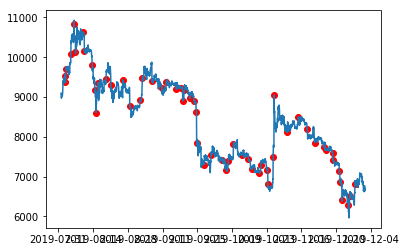

In [71]:
dVol = bd.getDailyVol(data.close['2019-08':])
tEvents = bd.getTEventsMod(np.log(data.close['2019-08':]),dVol*2)
plt.plot(data.close['2019-08':])
plt.scatter(tEvents,data.close[tEvents],color='red')

After sampling the events that are defines as a two standard deviation change we next need to decide what the prediction parameters should be. The predictions parameters include the target return and the holding period. Given a set of paramters the triple barrier method can be used to find the labels of the events. A good parameter set may be one that has at maximum 33% of 0 labels. Choosing too large target or too short a holding period influence the distribution of labels for the events.

In [6]:
t1 = bd.getVertT1(data.close['2019':],tEvents,2)
events = bd.getEvents(data.close['2019':],tEvents,1,dVol*2,dVol.min()*2,t1)
out = bd.getBins(events,data.close['2019':])

In [59]:
df = pd.DataFrame(events)
df['ret'] = out['ret']
df['bin'] = out['bin']
for i in df.index:
    if np.abs(df.loc[i,'ret'])<df.loc[i,'trgt']:
        df.loc[i,'bin']=0

In [62]:
print(len(df.loc[df['bin'] == 0]))
print(len(df.loc[df['bin'] == 1]))
print(len(df.loc[df['bin'] == -1]))

86
40
28


The below code will run through a set of different parameters and then save the resulting number of labels as a tuple in a list. The tuple is defined as: ( trgt: int, holding_period: int, num0labels: int, num1labels: int, num-1labels: int)

In [67]:
param_results=[]
for trgt in [0.5,1,1.5,2]:
    for hold_period in [0.5,1,2,3,4,5,6,7]:
        t1 = bd.getVertT1(data.close['2019':],tEvents,hold_period)
        events = bd.getEvents(data.close['2019':],tEvents,1,dVol*trgt,dVol.min()*trgt,t1)
        out = bd.getBins(events,data.close['2019':])
        df = pd.DataFrame(events)
        df['ret'] = out['ret']
        df['bin'] = out['bin']
        for i in df.index:
            if np.abs(df.loc[i,'ret'])<df.loc[i,'trgt']:
                df.loc[i,'bin']=0
        param_results.append((trgt,hold_period,len(df.loc[df['bin'] == 0]),len(df.loc[df['bin'] == 1]),len(df.loc[df['bin'] == -1])))

In [68]:
param_results

[(0.5, 0.5, 36, 67, 51),
 (0.5, 1, 11, 82, 61),
 (0.5, 2, 1, 90, 63),
 (0.5, 3, 0, 91, 63),
 (0.5, 4, 0, 91, 63),
 (0.5, 5, 0, 91, 63),
 (0.5, 6, 0, 91, 63),
 (0.5, 7, 0, 91, 63),
 (1, 0.5, 90, 37, 27),
 (1, 1, 48, 56, 50),
 (1, 2, 23, 69, 62),
 (1, 3, 19, 72, 63),
 (1, 4, 12, 75, 67),
 (1, 5, 6, 78, 70),
 (1, 6, 4, 79, 71),
 (1, 7, 4, 79, 71),
 (1.5, 0.5, 113, 24, 17),
 (1.5, 1, 80, 39, 35),
 (1.5, 2, 64, 50, 40),
 (1.5, 3, 39, 62, 53),
 (1.5, 4, 24, 71, 59),
 (1.5, 5, 18, 74, 61),
 (1.5, 6, 14, 76, 63),
 (1.5, 7, 11, 78, 64),
 (2, 0.5, 130, 13, 11),
 (2, 1, 99, 32, 23),
 (2, 2, 86, 40, 28),
 (2, 3, 63, 52, 39),
 (2, 4, 46, 60, 48),
 (2, 5, 39, 66, 48),
 (2, 6, 33, 70, 50),
 (2, 7, 29, 72, 52)]

Given a set ove paramters over a sample and the frequency distibution of the labels. How to decide which parameter set to choose? The end goal s to maximize returns. It might then be advisable to look at the returns distribution of each label.

In [7]:
data = pd.read_pickle(r'\crypto_forecast\data\raw\hour_sampled\XXBTZEUR_sampled.pkl')
trgt=2
hold_period=5
dVol = bd.getDailyVol(data.close)
tEvents = bd.getTEventsMod(np.log(data.close),dVol*2)
t1 = bd.getVertT1(data.close,tEvents,hold_period)
events = bd.getEvents(data.close,tEvents,1,dVol*trgt,dVol.min()*trgt,t1)
out = bd.getBins(events,data.close)
df = pd.DataFrame(events)
df['ret'] = out['ret']
df['bin'] = out['bin']
for i in df.index:
    if np.abs(df.loc[i,'ret'])<df.loc[i,'trgt']:
        df.loc[i,'bin']=0
print((trgt,hold_period,len(df.loc[df['bin'] == 0]),len(df.loc[df['bin'] == 1]),len(df.loc[df['bin'] == -1])))

(2, 5, 255, 483, 389)


c:\users\luciu\work\crypto_forecast\src\data\build_dataset.py:381: RuntimeWarning: invalid value encountered in sign
  out['bin']=np.sign(out['ret'])


In [75]:
len(events)

1130

In [75]:
data = pd.read_pickle(r'\crypto_forecast\data\raw\hour_sampled\XXMRZEUR_sampled.pkl')
trgt=2.0
hold_period=5
dVol = bd.getDailyVol(data.close)
tEvents = bd.getTEventsMod(np.log(data.close),dVol*2.0)
t1 = bd.getVertT1(data.close,tEvents,hold_period)
events = bd.getEvents(data.close,tEvents,1,dVol*trgt,dVol.min()*trgt,t1)
out = bd.getBins(events,data.close)
df = pd.DataFrame(events)
df['ret'] = out['ret']
df['bin'] = out['bin']
for i in df.index:
    if np.abs(df.loc[i,'ret'])<df.loc[i,'trgt']:
        df.loc[i,'bin']=0
print((trgt,hold_period,len(df.loc[df['bin'] == 0]),len(df.loc[df['bin'] == 1]),len(df.loc[df['bin'] == -1])))

(2.0, 5, 103, 212, 169)


c:\users\luciu\work\crypto_forecast\src\data\build_dataset.py:381: RuntimeWarning: invalid value encountered in sign
  out['bin']=np.sign(out['ret'])


In [58]:
def mpSampleW(t1,numCoEvents,close):
    '''
    WEIGHT to a sample for training of a ML algo.
    The weight is a function of the uniqueness and the returns.
    The results W then need to scale so that all w sum to num_samples:
    W = w*num_sample*(1/sum_w):
    W = w
    W *= W.shape[0]/W.sum()
    '''
    # Derive sample weight by return attribution
    # ret = data.close.astype(np.float64).apply(np.log).diff()
    ret = np.log(close).diff()
    wght=pd.Series(index=t1.index)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(ret.loc[tIn:tOut]/numCoEvents.loc[tIn:tOut]).sum()
    return wght.abs()

In [76]:
numCoEvents = bd.mpNumCoEvents(data.index, events.t1)
out['tW'] = bd.mpSampleTW(events.t1, numCoEvents)
out['W'] = mpSampleW(events.t1, numCoEvents, data.close)
out['W'] *= out.shape[0] / out['W'].sum()
td = data.index[-1] - data.index[0]
num_years = td.days / 365
decay_param = 1- (10 / 100) * num_years
dW = bd.getTimeDecay(out['tW'], clfLastW=decay_param)
out['dW'] = out['W'] * dW

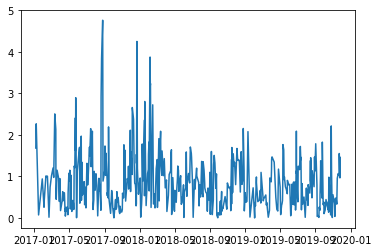

In [77]:
plt.plot(out.dW)

In [87]:
g=pd.read_pickle(r'\crypto_forecast\data\processed\hour_sampled\2.0_5_2.0_10.0\output_XXBTZEUR_sampled.pkl')
g.head()

,ret,bin,tW,W,dW
2013-10-03 01:00:00,0.182915,1.0,1.000000,3.000950,1.135267
2013-10-24 05:00:00,-0.363217,-1.0,0.727273,9.046885,3.427514
2013-10-24 07:00:00,0.110105,1.0,0.500000,0.749715,0.284326
2013-10-24 15:00:00,0.627907,1.0,0.500000,0.414250,0.157261
2013-10-24 16:00:00,-0.107143,-1.0,0.978261,3.726853,1.417624


In [89]:
len(g)

1129

In [82]:
g.tW.mean()

0.7212572384483757